# Part 2: Generalization across subjects
## Import required libraries

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import convolve1d

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, pairwise_distances, f1_score, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_validate
from scipy import stats

In [2]:
from functions import *

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

## Load and extract data

In [16]:
# Define the base path to the zip files and the extraction directory
base_zip_path = '../data/'
extraction_dir = '../data/'
figure_dir = '../output/'
id_column, emg, stimuli, repetitions = load_and_concatenate_subjects(base_path=base_zip_path, extraction_dir=extraction_dir, num_subjects=27, isZipped=False)

In [4]:
# print data shape
print('EMG shape:', emg.shape)
print('Stimulus shape:', stimuli.shape)
print('Repetitions shape:', repetitions.shape)

EMG shape: (2731393, 10)
Stimulus shape: (2731393, 1)
Repetitions shape: (2731393, 1)


## Preprocess data

In [5]:
# Apply bandpass filter to the data
emg_filtered = bandpass_filter(emg)

# Rectify the signal
emg_rectified = np.abs(emg_filtered)

# Envelop the signal using a moving average filter
mov_mean_size = 200
mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size
emg_envelopes = convolve1d(emg_rectified, weights=mov_mean_weights, axis=0) # convolve1d the rectified signal with the moving average weights

n_stimuli = len(np.unique(stimuli)) - 1 
n_repetitions = len(np.unique(repetitions)) - 1 

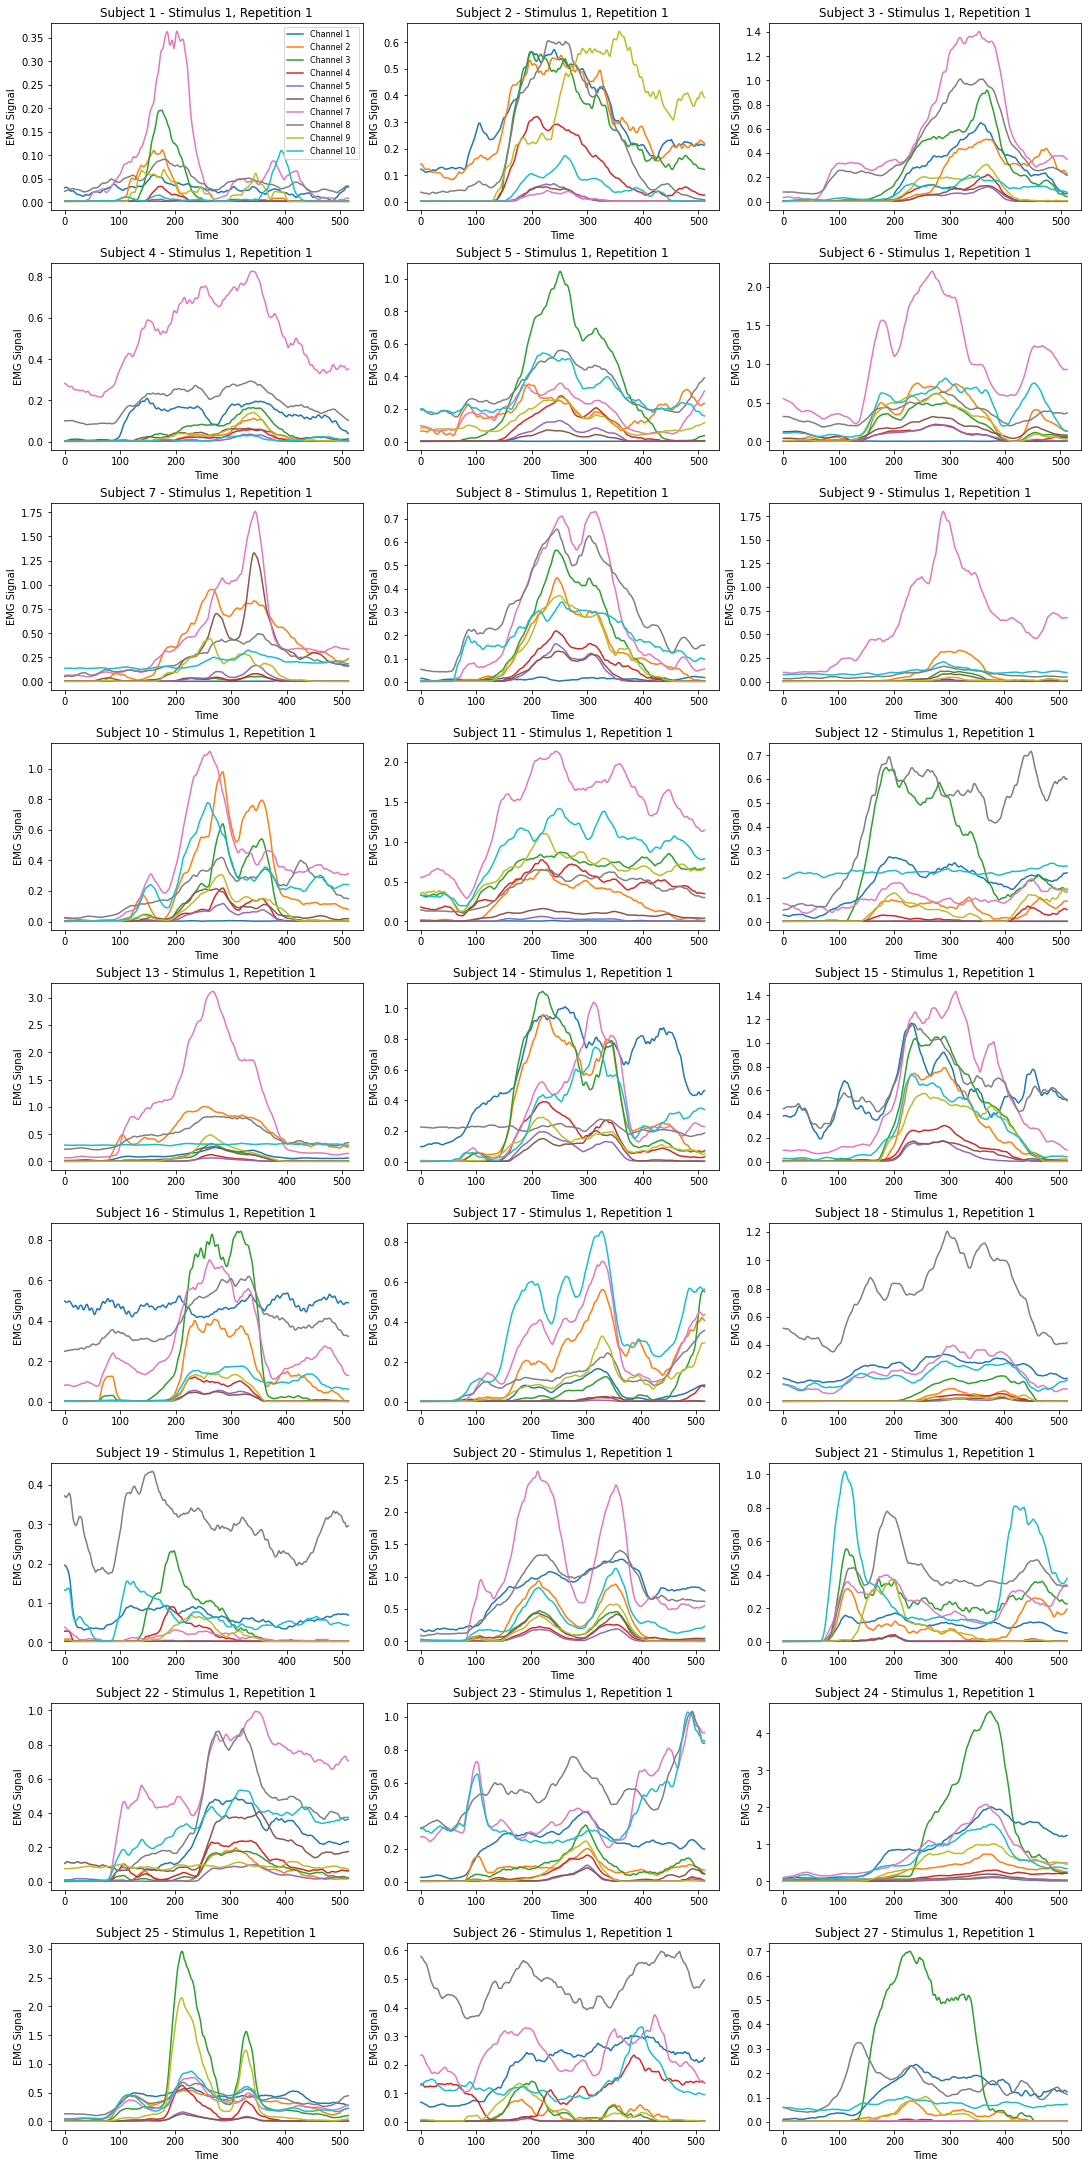

In [17]:
# Define the length of the moving average window
mov_mean_length = 25
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

# Number of subjects (adjust if needed)
unique_subjects = np.unique(id_column)

# Initialize a color map for distinct colors
def colors(index):
    """Return a color based on the index."""
    color_list = plt.cm.tab10.colors  # A predefined colormap
    return color_list[index % len(color_list)]

# Create a 9x3 layout for the plots
fig, axes = plt.subplots(9, 3, figsize=(15, 30), constrained_layout=True)
axes = axes.ravel()

# Iterate over all subjects and plot their emg_envelopes
for i, subject_num in enumerate(unique_subjects):
    # Filter data for the current subject
    subject_mask = id_column == subject_num
    emg_subject = emg[subject_mask, :]
    stimulus_subject = stimuli[subject_mask]
    repetition_subject = repetitions[subject_mask]

    # Initialize the data structure for current subject
    emg_windows_subject = [[None for _ in range(n_repetitions)] for _ in range(n_stimuli)]
    emg_envelopes_subject = [[None for _ in range(n_repetitions)] for _ in range(n_stimuli)]

    # Compute emg_windows and emg_envelopes for the current subject
    for stimuli_idx in range(n_stimuli):
        for repetition_idx in range(n_repetitions):
            idx = np.logical_and(stimulus_subject == stimuli_idx + 1, repetition_subject == repetition_idx + 1).flatten()
            emg_windows_subject[stimuli_idx][repetition_idx] = emg_subject[idx, :]
            emg_envelopes_subject[stimuli_idx][repetition_idx] = convolve1d(emg_windows_subject[stimuli_idx][repetition_idx], mov_mean_weights, axis=0)

    # Extract the emg envelope for the first stimulus and first repetition
    emg_envelope_first_stimuli_repetition = emg_envelopes_subject[0][0]

    # Plot the envelope for the first stimulus and first repetition
    ax = axes[i]
    for channel_idx in range(emg_envelope_first_stimuli_repetition.shape[1]):  # Iterate over channels
        ax.plot(emg_envelope_first_stimuli_repetition[:, channel_idx], color=colors(channel_idx), label=f'Channel {channel_idx+1}')
    ax.set_title(f"Subject {int(subject_num)} - Stimulus 1, Repetition 1")
    ax.set_xlabel("Time")
    ax.set_ylabel("EMG Signal")
    
    # Check for channels that are zero
    zero_channels = np.where(np.all(emg_envelope_first_stimuli_repetition == 0, axis=0))[0]

    # print the zero channels
    if zero_channels.size > 0: 
        print(f"Subject {int(subject_num)} has zero channels: {zero_channels}")


# Add a legend to the first subplot
axes[0].legend(loc='upper right', prop={'size': 8})
plt.savefig(figure_dir + 'emg_envelopes.png')
plt.show()

## Feature Extraction

In [7]:
# Build the dataset and labels
dataset, labels, subject_id_column = build_dataset_from_ninapro_all_subjects(
    subject_id_column=id_column,
    emg=emg,
    stimulus=stimuli,
    repetition=repetitions,
    features=[mav, std, maxav, rms, wl, ssc, total_power],
)

print(f"Dataset dimension: {dataset.shape}")
print(f"Labels dimension: {labels.shape}")
print(f"Subject ID column dimension: {subject_id_column.shape}")
feature_names = ["MAV", "STD", "MAXAV", "RMS", "WL", "SSC", "Total Power"]

Dataset dimension: (3240, 70)
Labels dimension: (3240,)
Subject ID column dimension: (3240,)


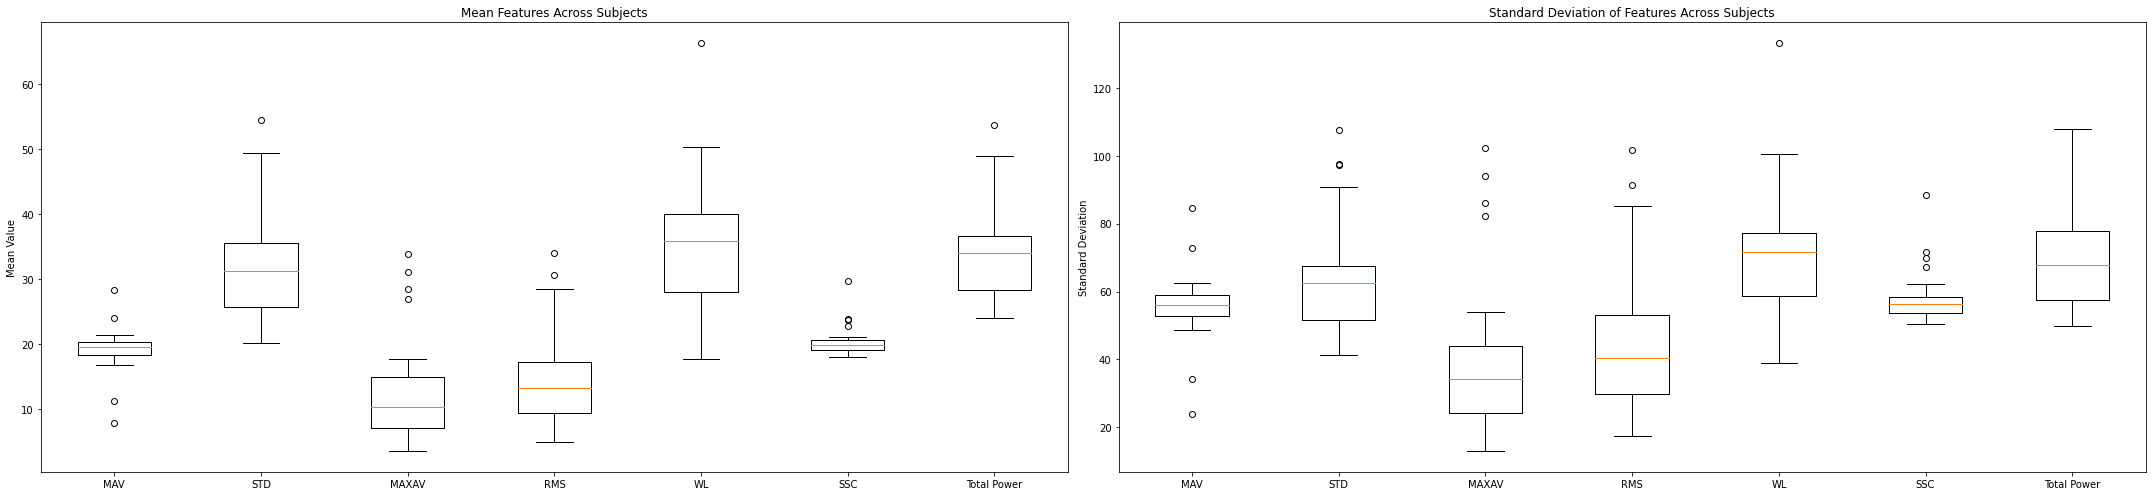

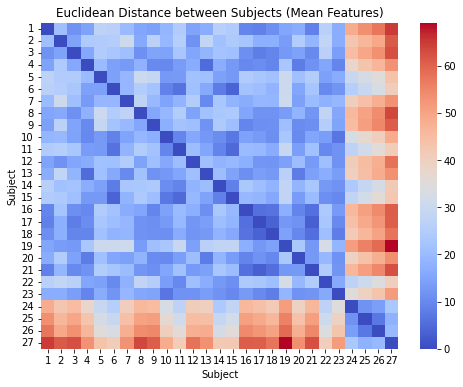

In [18]:
# Get unique subjects
unique_subjects = np.unique(subject_id_column).astype(int)
num_trials = 10 
n_features = int(dataset.shape[1] / num_trials)

# Initialize arrays to store the mean and std for each feature and subject
means_subjects = np.zeros((len(unique_subjects), n_features))
stds_subjects = np.zeros((len(unique_subjects), n_features))

# Reshape dataset for each subject's feature across trials
for i, subject in enumerate(unique_subjects):
    subject_mask = subject_id_column == subject
    emg_subject = dataset[subject_mask]  # Select the rows corresponding to the current subject
    # Reshape: Each feature will be grouped across trials for the current subject
    for feature_idx in range(n_features):
        feature_data = emg_subject[:, feature_idx*num_trials:(feature_idx+1)*num_trials]  # Select data for one feature
        means_subjects[i, feature_idx] = np.mean(feature_data)  # Mean across trials for the feature
        stds_subjects[i, feature_idx] = np.std(feature_data)    # Standard deviation across trials for the feature

# Visualize the mean and standard deviation of features across subjects
plt.figure(figsize=(30, 7))

# Plot mean features
plt.subplot(1, 2, 1)

plt.title('Mean Features Across Subjects')
plt.boxplot(means_subjects, labels=feature_names)
plt.ylabel('Mean Value')


# Plot std features
plt.subplot(1, 2, 2)
plt.title('Standard Deviation of Features Across Subjects')
plt.boxplot(stds_subjects, labels=feature_names)
plt.ylabel('Standard Deviation')
plt.tight_layout()
plt.savefig(figure_dir + 'mean_std_features_across_subjects.png')
plt.show()

# Compare similarity across subjects using Euclidean distance
distances = pairwise_distances(means_subjects, metric='euclidean')

# Visualize the Euclidean distance matrix between subjects
plt.figure(figsize=(8, 6))
sns.heatmap(distances, cmap='coolwarm', xticklabels=unique_subjects, yticklabels=unique_subjects)
plt.title("Euclidean Distance between Subjects (Mean Features)")
plt.xlabel("Subject")
plt.ylabel("Subject")
plt.savefig(figure_dir + 'euclidean_distance_between_subjects.png')
plt.show()

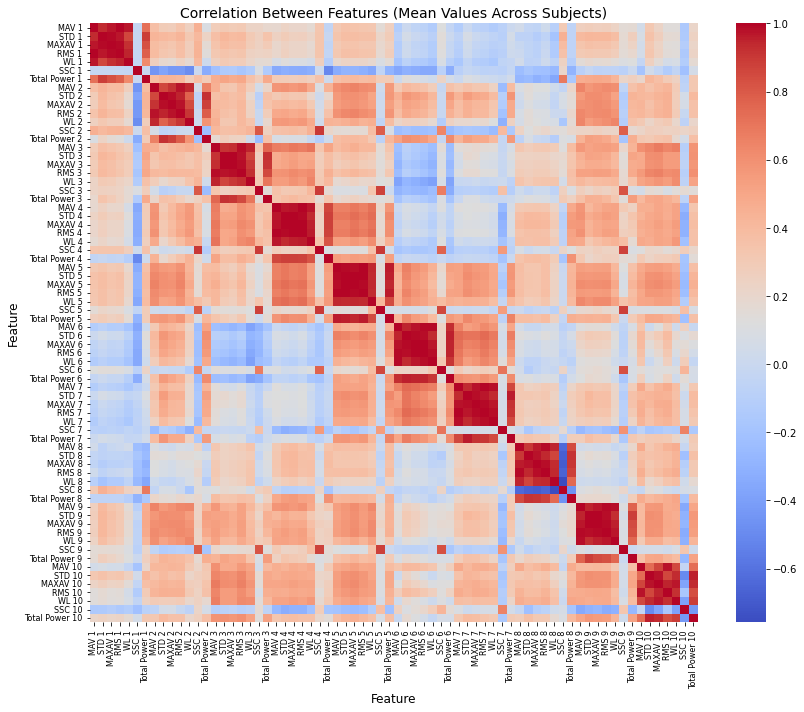

In [19]:

complete_feature_names = [f"{feature} {trial}" for trial in range(1, num_trials + 1) for feature in feature_names]
n_features = len(complete_feature_names)  # Total number of features (7 features × 10 trials)
unique_subjects = np.unique(subject_id_column)  # Unique subjects

# Initialize arrays to store the mean and std for each feature and subject
means_subjects = np.zeros((len(unique_subjects), n_features))
stds_subjects = np.zeros((len(unique_subjects), n_features))

# Calculate mean and std for each feature per subject
for i, subject in enumerate(unique_subjects):
    subject_mask = subject_id_column == subject
    means_subjects[i] = np.mean(dataset[subject_mask], axis=0)
    stds_subjects[i] = np.std(dataset[subject_mask], axis=0)

# Compute correlation across subjects for each feature
correlation_matrix = np.corrcoef(means_subjects, rowvar=False)

# Visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', xticklabels=complete_feature_names, yticklabels=complete_feature_names,
            annot=False, fmt=".2f", cbar=True)
plt.title("Correlation Between Features (Mean Values Across Subjects)", fontsize=14)
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig(figure_dir + 'correlation_matrix.png')
plt.show()

## Classifier

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best hyperparameters: {'bootstrap': False, 'max_depth': None, 'n_estimators': 1000}
F1 score: 0.13170675004008336


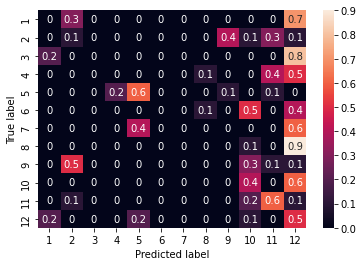

In [ ]:
# Create train from the first 26 subject and test with the last subejct
X_train = dataset[subject_id_column != 27]
y_train = labels[subject_id_column != 27]

X_test = dataset[subject_id_column == 27]
y_test = labels[subject_id_column == 27]

# Normalizing the data
# StandardScaler is used to scale the features so that they have a mean of 0 and a standard deviation of 1
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)  # Fit the scaler on the training data and transform it
X_test_z = scaler.transform(X_test)        # Transform the test data using the same scaler

# Train a classifier on the normalized data
# Perform grid search to find the best hyperparameters

param_grid = {
    'n_estimators': [100, 500, 1000, 2000],  # Varying the number of trees
    'max_depth': [None, 10, 20],   # Allowing a broader range for tree depth
    'bootstrap': [True, False],            # Using bootstrap samples or the whole dataset
}

# Initialize the classifier
clf = RandomForestClassifier(random_state=0)

# Perform grid search
grid_search = GridSearchCV(estimator = clf, 
                           param_grid = param_grid, 
                           cv=5,
                           scoring='f1_weighted',
                           verbose=1,
                           n_jobs=-1)

grid_search.fit(X_train_z, y_train)

# Get the best classifier from the grid search

clf = grid_search.best_estimator_
print(f"Best hyperparameters: {grid_search.best_params_}")

# Train the classifier on the training set
clf.fit(X_train_z, y_train)

# Predict the labels for the test set
y_pred = clf.predict(X_test_z)
# Calculate the f1 score of the model
f1Score = f1_score(y_test, y_pred, average='weighted')
print(f"F1 score: {f1Score}")

# Create a confusion matrix to visualize the performance of the classification
# The confusion matrix shows the true vs predicted labels
confmat = confusion_matrix(y_test, y_pred, normalize="true")
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)  # Use seaborn to create a heatmap of the confusion matrix
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
ax.set_xticklabels(range(1, len(confmat) + 1))
ax.set_yticklabels(range(1, len(confmat) + 1))
plt.savefig(figure_dir + 'confusion_matrix.png')
plt.show()

Subject used for testing : 1 - F1 score : 0.22979392588088238
Subject used for testing : 2 - F1 score : 0.06690705128205128
Subject used for testing : 3 - F1 score : 0.3458083837399694
Subject used for testing : 4 - F1 score : 0.2673020567649724
Subject used for testing : 5 - F1 score : 0.3319224996978056
Subject used for testing : 6 - F1 score : 0.1961138237301028
Subject used for testing : 7 - F1 score : 0.21981792717086837
Subject used for testing : 8 - F1 score : 0.38326130645775486
Subject used for testing : 9 - F1 score : 0.10573783256972913
Subject used for testing : 10 - F1 score : 0.46008376530688905
Subject used for testing : 11 - F1 score : 0.29793971460638136
Subject used for testing : 12 - F1 score : 0.27281717703151726
Subject used for testing : 13 - F1 score : 0.21251703208224948
Subject used for testing : 14 - F1 score : 0.26927343410102034
Subject used for testing : 15 - F1 score : 0.33253846207137366
Subject used for testing : 16 - F1 score : 0.3528283477308965
Subjec

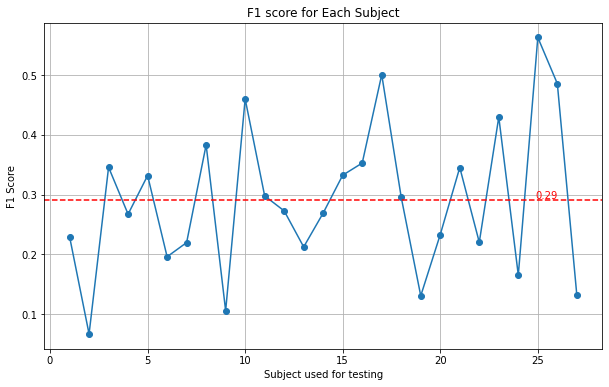

In [ ]:
f1_scores = []
# rotate the subject used for testing
for subject in range(1, 28):
    X_train = dataset[subject_id_column != subject]
    y_train = labels[subject_id_column != subject]

    X_test = dataset[subject_id_column == subject]
    y_test = labels[subject_id_column == subject]

    X_train_z = scaler.fit_transform(X_train)
    X_test_z = scaler.transform(X_test)

    clf = grid_search.best_estimator_
    clf.fit(X_train_z, y_train)

    y_pred = clf.predict(X_test_z)
    f1Score = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1Score)
    print(f"Subject used for testing : {subject} - F1 score : {f1Score}")

mean_f1 = np.mean(f1_scores)
# Plot the f1 score for each subject
plt.figure(figsize=(10, 6))
plt.plot(range(1, 28), f1_scores, marker='o')
plt.title("F1 score for Each Subject")
plt.axhline(mean_f1, color='r', linestyle='--', label='Mean F1 score')
plt.text(len(f1_scores) - 1, mean_f1, f'{mean_f1:.2f}', color='r', ha='right', va='bottom')
plt.xlabel("Subject used for testing")
plt.ylabel("F1 Score")
plt.grid(True)
plt.savefig(figure_dir + 'f1_score_subjects.png')
plt.show()

In [12]:
f1_scores = []
# rotate the subject used for testing
for subject in range(1, 27):
    X_train = dataset[subject_id_column <= subject]
    y_train = labels[subject_id_column <= subject]

    X_test = dataset[subject_id_column == 27]
    y_test = labels[subject_id_column == 27]

    X_train_z = scaler.fit_transform(X_train)
    X_test_z = scaler.transform(X_test)

    clf = grid_search.best_estimator_
    clf.fit(X_train_z, y_train)

    y_pred = clf.predict(X_test_z)
    f1Score = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1Score)
    print(f"{subject} Subjects used for training  - F1 score when predicting subject 27 : {f1Score}")

1 Subjects used for training  - F1 score when predicting subject 27 : 0.05555555555555556
2 Subjects used for training  - F1 score when predicting subject 27 : 0.09861595494587821
3 Subjects used for training  - F1 score when predicting subject 27 : 0.13460187353629977
4 Subjects used for training  - F1 score when predicting subject 27 : 0.0876750700280112
5 Subjects used for training  - F1 score when predicting subject 27 : 0.0903250773993808
6 Subjects used for training  - F1 score when predicting subject 27 : 0.09501881560705089
7 Subjects used for training  - F1 score when predicting subject 27 : 0.1087059827567814
8 Subjects used for training  - F1 score when predicting subject 27 : 0.11777904424181022
9 Subjects used for training  - F1 score when predicting subject 27 : 0.1390249433106576
10 Subjects used for training  - F1 score when predicting subject 27 : 0.10692640692640693
11 Subjects used for training  - F1 score when predicting subject 27 : 0.11727142289480431
12 Subjects 

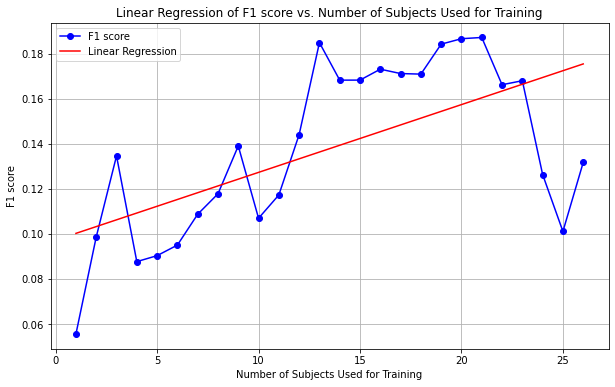

Regression coefficient: 0.00300892111496509
Regression intercept: 0.09720632890007956
R^2 score: 0.374994709649603


In [20]:
subject_range = range(1, 27)  # Subjects from 1 to 26
# 1. **Linear Regression to test for statistical increase**
X = np.array(subject_range).reshape(-1, 1)  # Number of subjects
y = np.array(f1_scores)  # Corresponding accuracies

# Fit a linear regression model
regressor = LinearRegression()
regressor.fit(X, y)

# Get the regression line
y_pred_regression = regressor.predict(X)

# Plot the linear regression result
plt.figure(figsize=(10, 6))
plt.plot(subject_range, f1_scores, color='blue', marker = 'o', label='F1 score')
plt.plot(subject_range, y_pred_regression, color='red', label='Linear Regression')
plt.title("Linear Regression of F1 score vs. Number of Subjects Used for Training")
plt.xlabel("Number of Subjects Used for Training")
plt.ylabel("F1 score")
plt.legend()
plt.grid(True)
plt.savefig(figure_dir + 'linear_regression_f1_score.png')
plt.show()

# print the regression coefficient
print(f"Regression coefficient: {regressor.coef_[0]}")
print(f"Regression intercept: {regressor.intercept_}")
print(f"R^2 score: {r2_score(y, y_pred_regression)}")
